# THE CHALLENGE

The problem we will be looking at is an image classification task on X-ray scans of the human body.

In this example, we focus on images of the spine which are frequently used during the planning of surgical procedures. 

An automated analysis of such images is thus an important feature.

The first step in such a process is to detect in which direction the X-ray was taken. Roughly speaking, there are two ways:

1. The X-rays traverse the body from front to back (or back to front). We call such images AP (stands for „anteroposterior”).

2. The X-rays traverse the body from left to right (or right to left). We call such images lateral.




In [262]:
import sys

import os 
from os import makedirs
from os import listdir

import shutil
from shutil import copyfile

from random import seed
from random import random


from matplotlib import pyplot
from matplotlib.image import imread
import matplotlib.pyplot as plt

#from PIL import Image
#from resizeimage import resizeimage
import cv2

from numpy import asarray
from numpy import save
from numpy import load
from numpy.random import seed
seed(42)

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.models import load_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



# data exploration

- show train and test set size
- plot some images



In [216]:
# define location of dataset
train_folder = '../SnkeOS_MLENgineer_ChallengeData/Train/'
test_folder = '../SnkeOS_MLENgineer_ChallengeData/Test/'

train_image_file = 'train_images.npy'
train_label_file = 'train_labels.npy'

test_image_file = 'test_images.npy'
test_label_file = 'test_labels.npy'

img_size = (256, 256)

lateral_label = 'Lateral'
ap_label = 'AP'


In [217]:
def get_img_files(folder, 
                  lateral_label='Lateral', 
                  ap_label='AP',
                 #images_file,
                 #labels_file,
                 #img_size=(256, 256),
                ):
    lateral_files = []
    ap_files = []
    files = []
    
    #labels = list()
    #images = list()
    for file_name in os.listdir(folder):
        label = ''
        if lateral_label in file_name:
            lateral_files.append(folder + file_name)
            label = 'Lateral'
        if ap_label in file_name:
            ap_files.append(folder + file_name)
            label = 'AP'
            
        #files.append(folder + file_name)
        #labels.append(label)
        # load image
        #image = load_img(folder + file_name, target_size=img_size)
        # convert to numpy array
        #image = img_to_array(image)
        #images.append(image)

    # convert to a numpy arrays
    #images = asarray(images)
    #labels = asarray(labels)
    #print(images.shape, labels.shape)

    # save the images
    #save(images_file, images)
    #save(labels_file, labels)
    
    return lateral_files, ap_files
    
    

In [218]:
train_lateral_files, train_ap_files = get_img_files(folder=train_folder)

print('number of train lateral images', len(train_lateral_files))
print('number of test ap images', len(train_ap_files))


number of train lateral images 83
number of test ap images 107


In [219]:
test_lateral_files, test_ap_files = get_img_files(folder=test_folder)                                                                           

print('number of test lateral images', len(test_lateral_files))
print('number of test ap images', len(test_ap_files))


number of test lateral images 13
number of test ap images 14


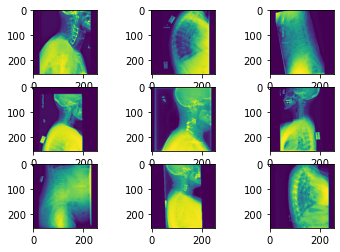

In [220]:
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = train_lateral_files[i]
    image = imread(filename)
    pyplot.imshow(image)

pyplot.show()



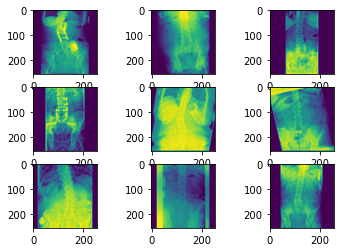

In [221]:
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = train_ap_files[i]
    image = imread(filename)
    pyplot.imshow(image)

pyplot.show()


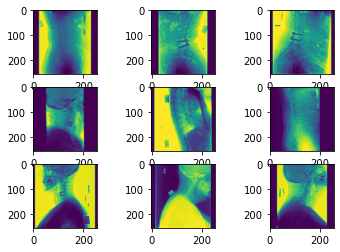

In [222]:
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = test_lateral_files[i]
    image = imread(filename)
    pyplot.imshow(image)

pyplot.show()


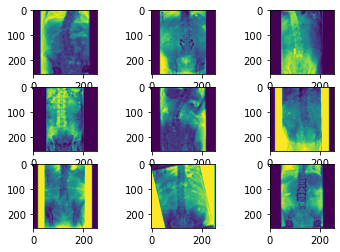

In [223]:
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = test_ap_files[i]
    image = imread(filename)
    pyplot.imshow(image)

pyplot.show()


# Prepare train, validation, and test sets

- randomly select 20% images from the train images as validation set
- save the train, validation, and test images into folders
- due to limited computing resources, images are resized


In [224]:
# create directories
dataset_home = 'lateral_vs_ap/'
subdirs = ['train/', 'test/', 'valid/', 'final_train/']
final_train_dir = dataset_home + subdirs[-1]
resize_img = (128, 128)
#resize_img = None
# define ratio of pictures to use for validation
val_ratio = 0.2
# seed random number generator
seed(42)


for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['lateral/', 'ap/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        if os.path.exists(newdir):
            shutil.rmtree(newdir)
        makedirs(newdir, exist_ok=False)

        
# copy training and testing dataset images into subdirectories
def save_images(src_directory, dataset_home, dst_dir_input, resize_img, val_ratio=0):
    for file in listdir(src_directory):
        src = src_directory + '/' + file
        
        dst_dir = dst_dir_input
        if val_ratio and random() < val_ratio:
            dst_dir = 'valid/'
        
        dst = ''
        if 'Lateral' in file:
            dst = dataset_home + dst_dir + 'lateral/'  + file
            copyfile(src, dst)
        if 'AP' in file:
            dst = dataset_home + dst_dir + 'ap/'  + file
            copyfile(src, dst)
        
        # resize image
        if resize_img:
            src = cv2.imread(dst, cv2.IMREAD_UNCHANGED)
            output = cv2.resize(src, resize_img)
            cv2.imwrite(dst, output) 
    
    
# create train and validation set
save_images(train_folder, dataset_home, 'train/', resize_img, val_ratio)
# create test set
save_images(test_folder, dataset_home, 'test/', resize_img)
# create final train set
save_images(train_folder, dataset_home, 'final_train/', resize_img)


# model creation


## baseline CNN model

- develop a baseline convolutional neural network model based on the VGG models
https://arxiv.org/abs/1409.1556


    - stacking convolutional layers with small 3×3 filters followed by a max pooling layer. 
    - these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. 
    - padding is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.
    - each layer will use the ReLU activation function and the He weight initialization, which are generally best practices.
    - the model will be fit with stochastic gradient descent (SGD).
    - the output layer with 1 node and a sigmoid activation will be used because it is a binary classification problem.
    - the model will be optimized using the binary cross-entropy loss function.
    - the model will be fit 10 epochs
    - the model can be evaluated on the test dataset directly and the classification accuracy reported.



In [225]:

img_shape = (256, 256, 3)
if resize_img:
    img_shape = (resize_img[0], resize_img[1], 3)


In [226]:
def create_baseline_model(img_shape=(256, 256, 3)):
    """
    Define a baseline model
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), 
                     activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same', 
                     input_shape=img_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model
 

def plot_learning_curves(history):
    """
    Plot the learing curves
    """
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()
    image = imread(filename + '_plot.png')
    pyplot.figure(figsize=(10, 15))
    pyplot.imshow(image)

    
def run_test(model,
             img_size=(256, 256),
             epochs=20,
             augment_data=False,
             train_folder='lateral_vs_ap/train/',
             valid_folder='lateral_vs_ap/valid/',
             test_folder='lateral_vs_ap/test/',
            ):
    """
    # run the test harness for evaluating a model
    """
    #model = baseline_model()
    
    # scale the pixel values to the range of 0-1.
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    # prepare iterators
    if augment_data:
        train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                           width_shift_range=0.1, 
                                           height_shift_range=0.1, 
                                           horizontal_flip=True,
                                          )
            
        train_it = train_datagen.flow_from_directory(train_folder,
                                                     class_mode='binary', 
                                                     batch_size=64, 
                                                     target_size=img_size,
                                                    )
    else:
        train_it = datagen.flow_from_directory(train_folder,
                                               class_mode='binary', 
                                               batch_size=64, 
                                               target_size=img_size,
                                              )
    
    valid_it = datagen.flow_from_directory(valid_folder,
                                           class_mode='binary', 
                                           batch_size=64, 
                                           target_size=img_size,
                                          )
    
    test_it = datagen.flow_from_directory(test_folder,
                                          class_mode='binary', 
                                          batch_size=64, 
                                          target_size=img_size,
                                         )
    # fit model
    history = model.fit_generator(train_it, 
                                  steps_per_epoch=len(train_it),
                                  validation_data=valid_it, 
                                  validation_steps=len(valid_it), 
                                  epochs=epochs, 
                                  verbose=0,
                                 )
    # evaluate model
    _, acc = model.evaluate_generator(train_it, steps=len(train_it), verbose=0)
    print('train accuracy %.3f' % (acc * 100.0))
    _, acc = model.evaluate_generator(valid_it, steps=len(valid_it), verbose=0)
    print('validation accuracy %.3f' % (acc * 100.0))
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('test accuracy %.3f' % (acc * 100.0))
    # learning curves
    plot_learning_curves(history)






Found 159 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 99.371
validation accuracy 90.323
test accuracy 44.444


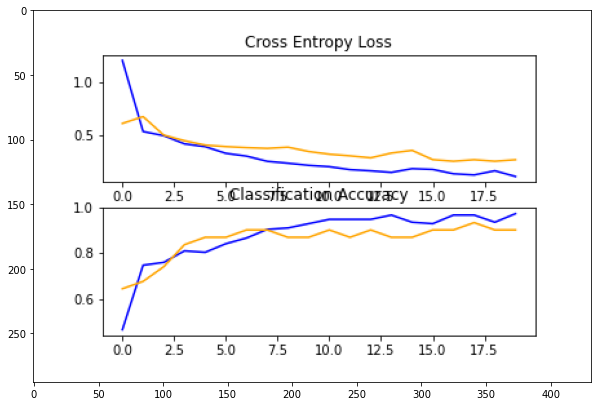

In [227]:
baseline_model = create_baseline_model(img_shape=img_shape)
run_test(model=baseline_model, img_size=(img_shape[0], img_shape[1]), epochs=20)


Found 159 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 93.082
validation accuracy 90.323
test accuracy 44.444


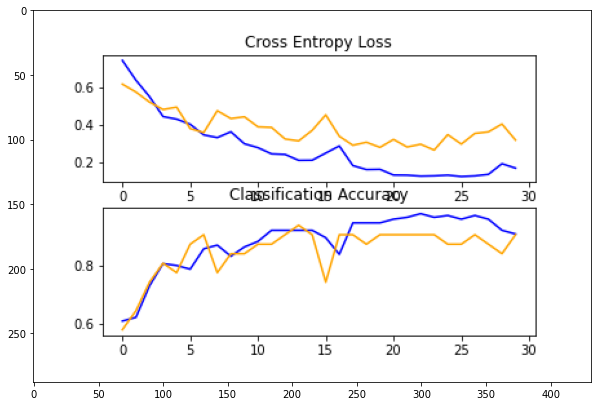

In [228]:
baseline_model = create_baseline_model(img_shape=img_shape)
run_test(model=baseline_model, img_size=(img_shape[0], img_shape[1]), epochs=30)


## VGG model

- two-block vgg model
- three-block vgg model


In [229]:
def create_two_block_vgg_model(img_shape=(256, 256, 3)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=img_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model



Found 159 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 98.113
validation accuracy 90.323
test accuracy 44.444


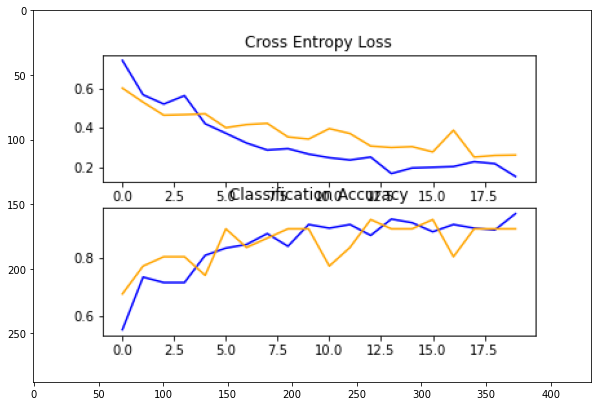

In [230]:
two_block_vgg_model = create_two_block_vgg_model(img_shape=img_shape)
run_test(model=two_block_vgg_model, img_size=(img_shape[0], img_shape[1]), epochs=20)



Found 159 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 98.113
validation accuracy 90.323
test accuracy 51.852


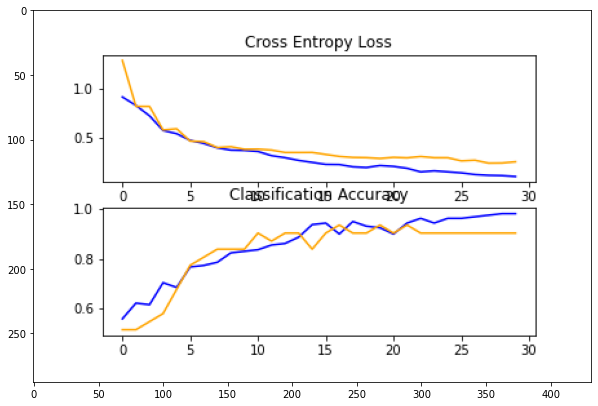

In [231]:
two_block_vgg_model = create_two_block_vgg_model(img_shape=img_shape)
run_test(model=two_block_vgg_model, img_size=(img_shape[0], img_shape[1]), epochs=30)



In [232]:
# define cnn model
def create_three_block_vgg_model(img_shape=(256, 256, 3)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=img_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


Found 159 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 94.969
validation accuracy 90.323
test accuracy 62.963


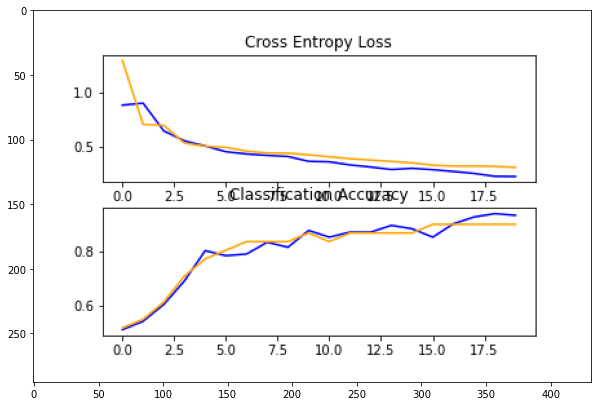

In [233]:
three_block_vgg_model = create_three_block_vgg_model(img_shape=img_shape)
run_test(model=three_block_vgg_model, img_size=(img_shape[0], img_shape[1]), epochs=20)



Found 159 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 99.371
validation accuracy 90.323
test accuracy 62.963


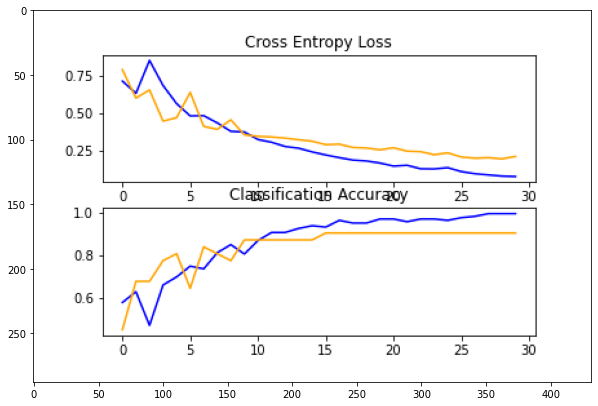

In [234]:
three_block_vgg_model = create_three_block_vgg_model(img_shape=img_shape)
run_test(model=three_block_vgg_model, img_size=(img_shape[0], img_shape[1]), epochs=30)



## model improvement



### dropout regularization

Dropout works by probabilistically removing inputs to a layer, 
which may be input variables in the data sample or activations from a previous layer. 

It has the effect of simulating a large number of networks with very different network structures and 
makes nodes in the network generally more robust to the inputs.


https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/


In [235]:
def create_vgg_model(img_shape=(256, 256, 3)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=img_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    #model.add(Dropout(0.5))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


Found 159 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 83.648
validation accuracy 93.548
test accuracy 59.259


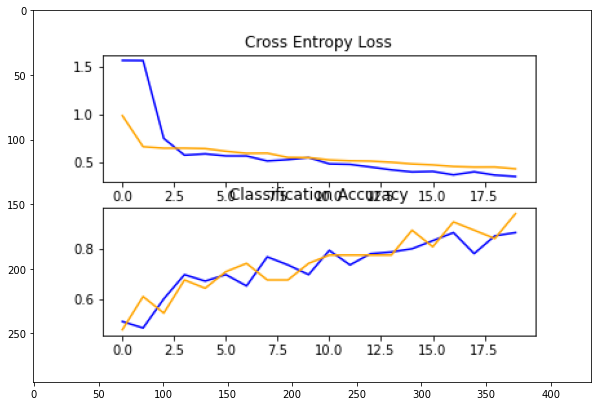

In [236]:
vgg_model = create_vgg_model(img_shape=img_shape)
run_test(model=vgg_model, img_size=(img_shape[0], img_shape[1]), epochs=20)


Found 159 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 93.711
validation accuracy 90.323
test accuracy 66.667


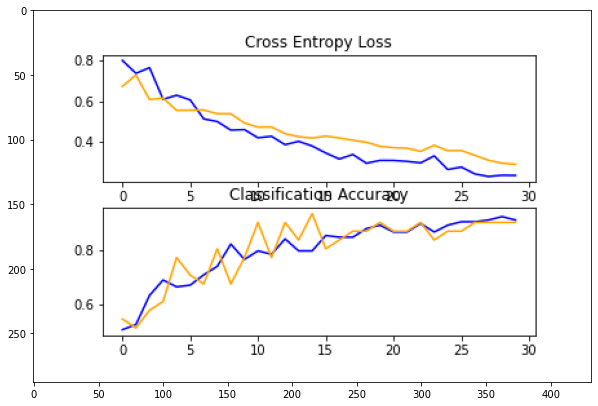

In [237]:
vgg_model = create_vgg_model(img_shape=img_shape)
run_test(model=vgg_model, img_size=(img_shape[0], img_shape[1]), epochs=30)


### data augmentation


Found 159 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 72.956
validation accuracy 83.871
test accuracy 66.667


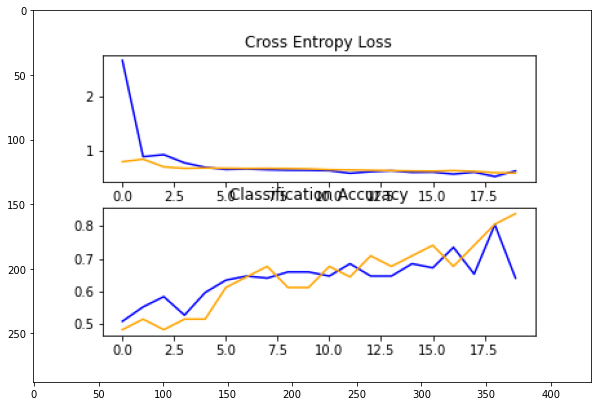

In [238]:
vgg_model = create_vgg_model(img_shape=img_shape)
run_test(model=vgg_model, img_size=(img_shape[0], img_shape[1]), epochs=20, augment_data=True)


Found 159 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 76.730
validation accuracy 90.323
test accuracy 70.370


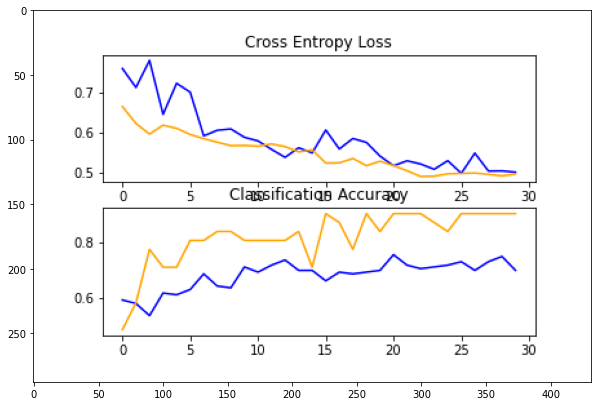

In [239]:
vgg_model = create_vgg_model(img_shape=img_shape)
run_test(model=vgg_model, img_size=(img_shape[0], img_shape[1]), epochs=30, augment_data=True)


## transfer learning


### VGG16

In [240]:

def create_vgg16_model(img_shape=(256, 256, 3)):
    model = VGG16(include_top=False, input_shape=img_shape)
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


Found 159 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 95.597
validation accuracy 96.774
test accuracy 81.481


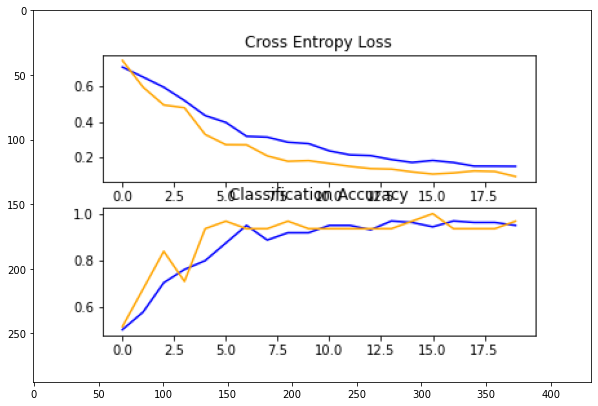

In [241]:
vgg16_model = create_vgg16_model(img_shape=img_shape)
run_test(model=vgg16_model, img_size=(img_shape[0], img_shape[1]), epochs=20, augment_data=True)


Found 159 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 97.484
validation accuracy 93.548
test accuracy 85.185


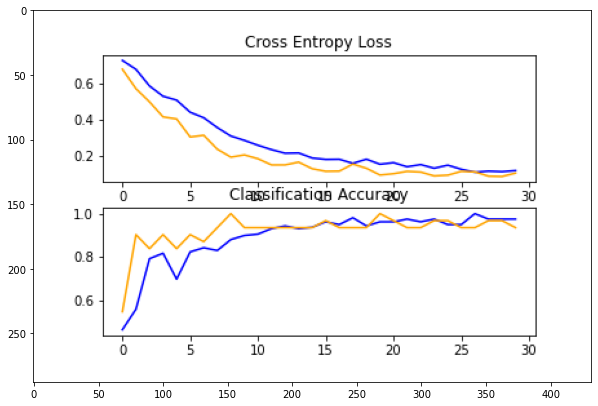

In [242]:
vgg16_model = create_vgg16_model(img_shape=img_shape)
run_test(model=vgg16_model, img_size=(img_shape[0], img_shape[1]), epochs=30, augment_data=True)


Found 159 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 96.855
validation accuracy 96.774
test accuracy 85.185


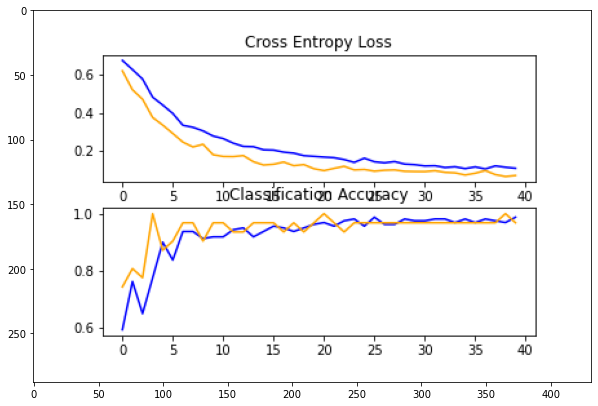

In [243]:
vgg16_model = create_vgg16_model(img_shape=img_shape)
run_test(model=vgg16_model, img_size=(img_shape[0], img_shape[1]), epochs=40, augment_data=True)


In [ ]:
vgg16_model = create_vgg16_model(img_shape=img_shape)
run_test(model=vgg16_model, img_size=(img_shape[0], img_shape[1]), epochs=50, augment_data=True)


### ResNet50


In [263]:
def create_resnet50_model(img_shape=(256, 256, 3)):
    model = ResNet50(include_top=False, input_shape=img_shape)
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


94773248/94765736 [==============================] - 32s 0us/step
Found 159 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
train accuracy 56.604
validation accuracy 74.194
test accuracy 70.370


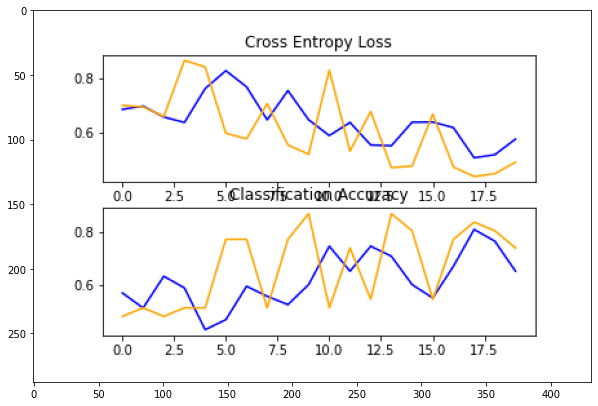

In [264]:
resnet50_model = create_resnet50_model(img_shape=img_shape)
run_test(model=resnet50_model, img_size=(img_shape[0], img_shape[1]), epochs=20, augment_data=True)



In [ ]:
resnet50_model = create_resnet50_model(img_shape=img_shape)
run_test(model=resnet50_model, img_size=(img_shape[0], img_shape[1]), epochs=50, augment_data=True)


Found 159 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


### InceptionV3


In [ ]:
def create_inceptionv3_model(img_shape=(256, 256, 3)):
    model = InceptionV3(include_top=False, input_shape=img_shape)
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
inceptionv3_model = create_inceptionv3_model(img_shape=img_shape)
run_test(model=inceptionv3_model, img_size=(img_shape[0], img_shape[1]), epochs=20, augment_data=True)



In [ ]:
inceptionv3_model = create_inceptionv3_model(img_shape=img_shape)
run_test(model=inceptionv3_model, img_size=(img_shape[0], img_shape[1]), epochs=50, augment_data=True)


# result evaluation


## train and save final model


In [244]:
def train_vgg16_final(img_shape=(128, 128, 3), epochs=20):
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       width_shift_range=0.1, 
                                       height_shift_range=0.1, 
                                       horizontal_flip=True,
                                      )

    train_it = train_datagen.flow_from_directory(final_train_dir,
                                                 class_mode='binary', 
                                                 batch_size=64, 
                                                 target_size=(img_shape[0], img_shape[1]),
                                                )


    vgg16_model = create_vgg16_model(img_shape=img_shape)
    vgg16_model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=epochs, verbose=0)

    vgg16_model.save('vgg16_model.h5')
    print('the final model is saved in vgg16_model.h5')
    
    return



In [256]:
train_vgg16_final(img_shape=img_shape, epochs=50)


Found 190 images belonging to 2 classes.
the final model is saved in vgg16_model.h5


## make prediction 

In [257]:
vgg16_model = load_model('vgg16_model.h5')

test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_directory('lateral_vs_ap/test/',
                                                  class_mode='binary', 
                                                  batch_size=64, 
                                                  target_size=(img_shape[0], img_shape[1]),
                                                 )

preds = vgg16_model.predict_generator(test_generator)


Found 27 images belonging to 2 classes.


In [258]:
test_images, test_labels = test_generator.next()

print(len(test_labels))

#for i in range(0, 10):
#    image = x[i]
#    label = y[i]
#    print (label)
#    plt.imshow(image)
#    plt.show()
    

27


In [259]:
preds

array([[8.6056602e-01],
       [1.2905002e-03],
       [1.6426444e-03],
       [1.5604496e-02],
       [8.5872710e-03],
       [9.9466825e-01],
       [9.1840541e-01],
       [2.3995638e-02],
       [8.2533622e-01],
       [1.4517307e-03],
       [1.2247711e-02],
       [4.7445694e-01],
       [2.8531253e-03],
       [6.1814785e-03],
       [3.2809675e-03],
       [9.9711621e-01],
       [1.6681841e-01],
       [7.7686715e-01],
       [5.0435501e-01],
       [9.6002698e-01],
       [6.2894970e-01],
       [6.3860416e-04],
       [7.1192056e-02],
       [3.4994990e-01],
       [2.0961165e-03],
       [3.5052261e-01],
       [9.8770785e-01]], dtype=float32)

In [260]:
pred_labels = preds > 0.5

confusion_matrix(test_labels, pred_labels)


array([[9, 5],
       [8, 5]])

In [261]:
target_names = ['ap', 'lateral']
print(classification_report(test_labels, pred_labels, target_names=target_names))


              precision    recall  f1-score   support

          ap       0.53      0.64      0.58        14
     lateral       0.50      0.38      0.43        13

    accuracy                           0.52        27
   macro avg       0.51      0.51      0.51        27
weighted avg       0.52      0.52      0.51        27



# troubleshooting


## plot correctly classified images

- class 0 -> ap
- class 1 -> lateral



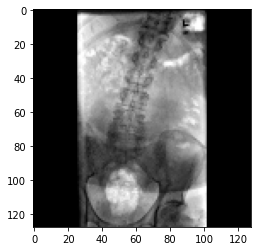

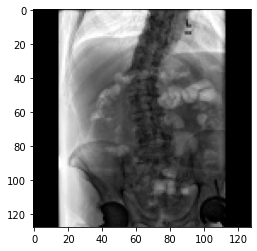

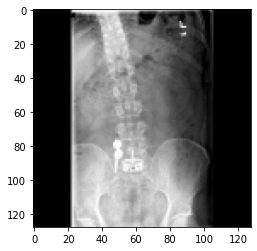

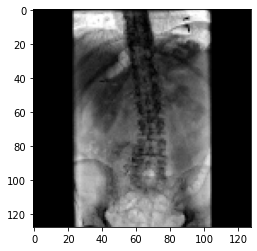

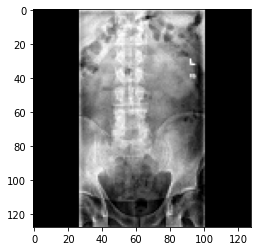

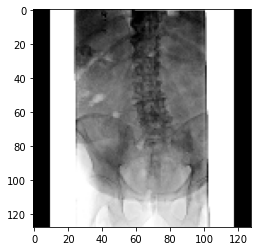

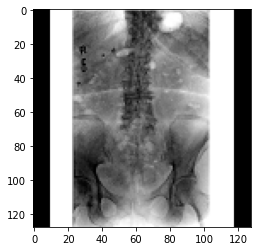

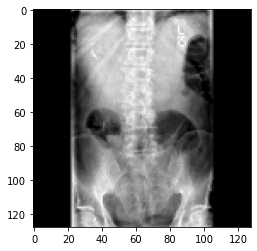

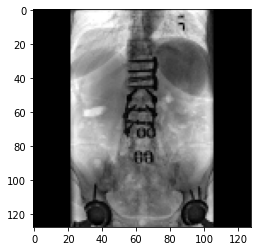

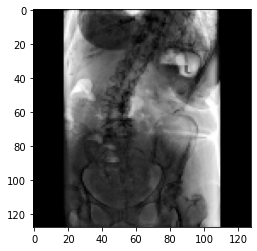

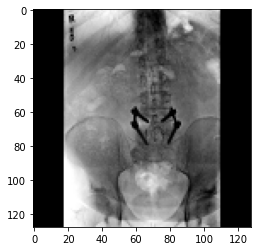

In [252]:
for i in range(len(test_labels)):
    if test_labels[i] == 0 and test_labels[i] == pred_labels[i]:
        image = test_images[i]
        plt.imshow(image)
        plt.show()
        

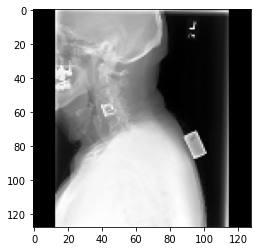

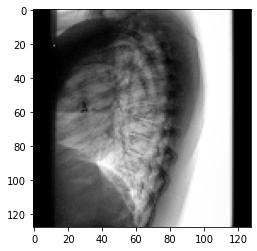

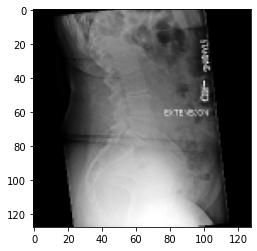

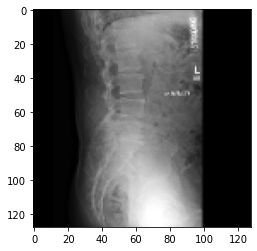

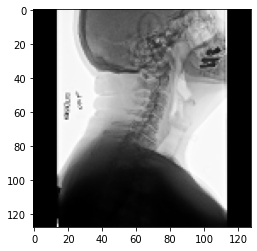

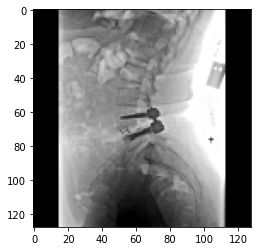

In [253]:
for i in range(len(test_labels)):
    if test_labels[i] == 1 and test_labels[i] == pred_labels[i]:
        image = test_images[i]
        plt.imshow(image)
        plt.show()
        

## plot misclassified images


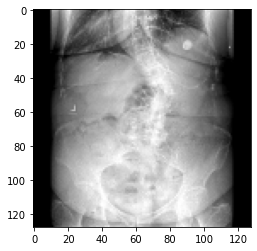

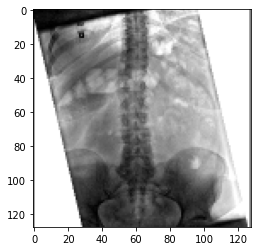

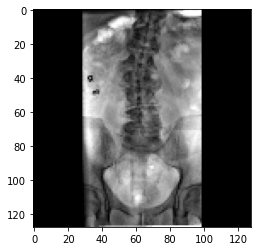

In [254]:
for i in range(len(test_labels)):
    if test_labels[i] == 0 and test_labels[i] != pred_labels[i]:
        image = test_images[i]
        plt.imshow(image)
        plt.show()
        
    

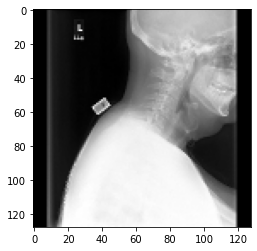

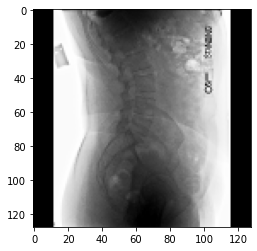

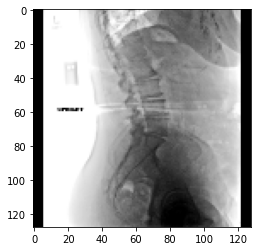

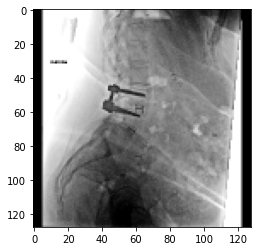

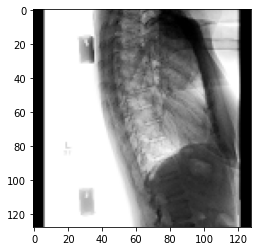

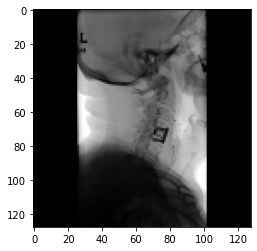

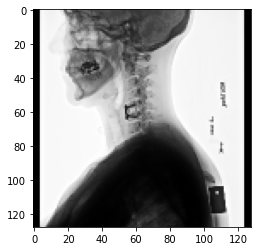

In [255]:
for i in range(len(test_labels)):
    if test_labels[i] == 1 and test_labels[i] != pred_labels[i]:
        image = test_images[i]
        plt.imshow(image)
        plt.show()
        

In [ ]:
"""
# load and prepare the image
def load_image(filename, img_size=(128, 128)):
    img = load_img(filename, target_size=img_size)
    img = img_to_array(img)
    img = img.reshape(1, img_size[0], img_size[1], 3)
    img = img.astype('float32')
    return img

# class 0
test_lateral_dir = 'lateral_vs_ap/test/lateral/'
nb = 0
for file in listdir(test_lateral_dir):
    test_img = load_image(test_lateral_dir + file)
    pred_label = vgg16_model.predict(test_img)
    if pred_label[0][0] == 1:
        image = imread(test_lateral_dir + file)
        plt.imshow(image)
        plt.show()
        nb += 1
print(nb)
    
# class 1
test_ap_dir = 'lateral_vs_ap/test/ap/'
nb = 0
for file in listdir(test_ap_dir):
    test_img = load_image(test_ap_dir + file)
    pred_label = vgg16_model.predict(test_img)
    if pred_label[0][0] == 0:
        image = imread(test_ap_dir + file)
        plt.imshow(image)
        plt.show()
        nb += 1
print(nb)
"""


# Reference

* Collection! Deep learning must read 10 classic algorithm paper summary!

https://developpaper.com/collection-deep-learning-must-read-10-classic-algorithm-paper-summary/


* How to Classify Photos of Dogs and Cats (with 97% accuracy)

https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/



* Convolutional Neural Networks, Coursera, deeplearning.ai

https://www.coursera.org/learn/convolutional-neural-networks


* Deep Learning vs. Traditional Computer Vision

https://arxiv.org/pdf/1910.13796.pdf


* Image Classification

https://paperswithcode.com/task/image-classification



* Building powerful image classification models using very little data

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html


* Dog vs Cat, kaggle competition

https://www.kaggle.com/c/dogs-vs-cats


* N-Shot Learning: Learning More with Less Data

https://blog.floydhub.com/n-shot-learning/


* Transfer Learning in Keras with Computer Vision Models

https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/


* Is deep learning applicable for small data sets of 200 images in image classification?

https://www.quora.com/Is-deep-learning-applicable-for-small-data-sets-of-200-images-in-image-classification

